# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Helper Functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def auto_canny(image, sigma=0.33):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    return edged

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def median_blur(img, kernel_size):
    """Applies a median Noise kernel"""
    return cv2.medianBlur(img, kernel_size)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillConvexPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def show_image(image, is_debug=False):
    if is_debug:
        plt.figure()
        plt.imshow(image)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

In [4]:
def find_lane(image, is_debug=False):
    h, w = (image.shape[0], image.shape[1])
    w_top = int(round(w*0.4))
    h_top = int(round(h*0.45))
    left_top = (w_top, h_top)
    right_top = (w-w_top, h_top)
    left_bottom = (0, h)
    right_bottom = (w, h)
    vertices = np.array([left_top, right_top, right_bottom, left_bottom], dtype=int)
    
    image_gaussian = gaussian_blur(image, 5)
    image_median = median_blur(image, 5)

    roi_image = region_of_interest(image_median, vertices)
    roi_hsv = cv2.cvtColor(roi_image, cv2.COLOR_BGR2HSV)

    lower_white = np.array([0, 0, 200])
    upper_white = np.array([255, 55, 255])
    lower_yello = np.array([80, 80, 80])
    upper_yello = np.array([120, 255, 255])
    
    white_mask = cv2.inRange(roi_hsv, lower_white, upper_white)
    yello_mask = cv2.inRange(roi_hsv, lower_yello, upper_yello)

    wy_mask = cv2.bitwise_or(white_mask, yello_mask)

    kernel_dilate = np.ones((9,9), np.uint8)
    dilated_wy_mask = cv2.dilate(wy_mask, kernel_dilate, iterations=1)
    
    roi_image_wy = cv2.bitwise_and(roi_image, roi_image, mask=dilated_wy_mask)
    canny_edges = auto_canny(image_gaussian)
    canny_edges_wy = cv2.bitwise_and(canny_edges, canny_edges, mask=dilated_wy_mask)
    
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_length = 10
    max_line_gap = 20
    
    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(canny_edges_wy, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    
    right_k = np.empty(0)
    right_b = np.empty(0)
    left_k = np.empty(0)
    left_b = np.empty(0)
    # Iterate over the output "lines" and draw lines on the blank
    for id in range(len(lines)):
        for x1,y1,x2,y2 in lines[id]:
            dx = x2 - x1
            dy = y2 - y1
            deg = int(round(np.rad2deg(np.arctan2(dy, dx))))
            if deg < 0:
                deg += 180
            poly_coeff = np.polyfit((y1, y2), (x1, x2), 1)
            if deg > 25 and deg < 40:
                right_k = np.append(right_k, poly_coeff[0])
                right_b = np.append(right_b, poly_coeff[1]) 
            elif deg > 135 and deg < 150:
                left_k = np.append(left_k, poly_coeff[0])
                left_b = np.append(left_b, poly_coeff[1])
                
    right_k = np.median(right_k)
    right_b = np.median(right_b)
    left_k = np.median(left_k)
    left_b = np.median(left_b)

    intersection_y = (left_b - right_b)/(right_k - left_k)
    
    right_line_func = np.poly1d((right_k, right_b))
    left_line_func = np.poly1d((left_k, left_b))

    image_lines = np.copy(image)*0
    y1 = int(intersection_y)
    y2 = h
    
    x1 = int(round(right_line_func(y1)))
    x2 = int(round(right_line_func(y2)))
    cv2.line(image_lines, (x1, y1), (x2, y2), [255, 0, 0], 10)
    
    x1 = int(round(left_line_func(y1)))
    x2 = int(round(left_line_func(y2)))
    cv2.line(image_lines, (x1, y1), (x2, y2), [0, 255, 0], 10)
    
    image_lines = weighted_img(image_lines, image, α=0.8, β=1., γ=0.)
    show_image(image_lines, is_debug)
    return image_lines

## Test data

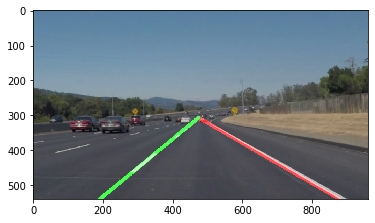

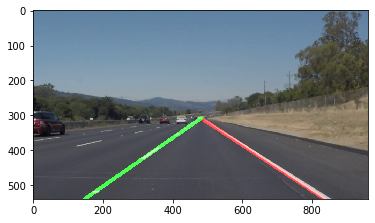

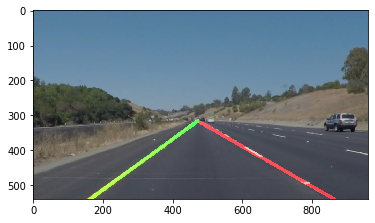

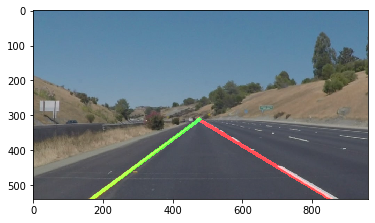

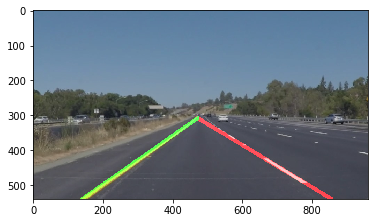

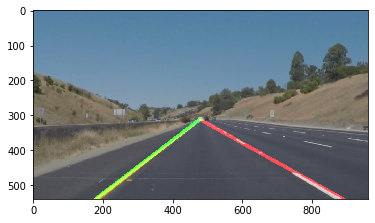

In [5]:
import os

in_img_folder = "test_images/"

list_of_images = os.listdir(in_img_folder)
for image_name in list_of_images: 
    image = mpimg.imread(in_img_folder+image_name)
    find_lane(image, True)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

Let's try the one with the solid white lane on the right first ...

In [6]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(find_lane) #NOTE: thi|s function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 7.92 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [8]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(find_lane)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 23.9 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [10]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_|second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(find_lane)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 19.1 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))